In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Read dataset

In [130]:
species2genus = torch.load('tensor_dataset/species2genus.pt')
described_species_train = torch.load('tensor_dataset/described_species_labels_train.pt')
described_species_trainval = torch.load('tensor_dataset/described_species_labels_trainval.pt')
described_species_labels = described_species_train

In [131]:
expanded_train_dna_features = torch.load('dna_train_features.pt')
expanded_train_dna_labels = torch.load('dna_train_labels.pt')
image_train_features = torch.load('img_train_features.pt')
image_train_labels= torch.load('img_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [132]:
expanded_val_dna_features = torch.load('dna_val_features.pt')
expanded_val_dna_labels = torch.load('dna_val_labels.pt')
image_val_features = torch.load('img_val_features.pt')
image_val_labels = torch.load('img_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [133]:
expanded_test_dna_features = torch.load('dna_test_features.pt')
expanded_test_dna_labels = torch.load('dna_test_labels.pt')
image_test_features = torch.load('img_test_features.pt')
image_test_labels = torch.load('img_test_labels.pt')
assert((image_test_labels == expanded_test_dna_labels).all())
n_classes = 1050

In [150]:
torch.load('tensor_dataset/all_dnas.pt').mean()

tensor(0.1997, dtype=torch.float64)

In [134]:
import scipy.io as io
using_matlab_dataset  = False
if using_matlab_dataset:
    dset = io.loadmat('matlab_dataset/insect_dataset.mat') 
    all_dna_features_cnn_original = dset['all_dna_features_cnn_original']
    all_image_features_resnet = dset['all_image_features_resnet']
    train_loc = np.squeeze(dset['train_loc']-1)
    val_seen_loc = np.squeeze(dset['val_seen_loc']-1)
    val_unseen_loc = np.squeeze(dset['val_unseen_loc']-1)
    test_seen_loc = np.squeeze(dset['test_seen_loc']-1)
    test_unseen_loc = np.squeeze(dset['test_unseen_loc']-1)
    expanded_train_dna_features = torch.tensor(all_dna_features_cnn_original[train_loc])
    expanded_val_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((val_seen_loc,val_unseen_loc))])
    expanded_test_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((test_seen_loc,test_unseen_loc))])
    
    image_train_features = torch.tensor(all_image_features_resnet[train_loc])
    image_val_features = torch.tensor(all_image_features_resnet[np.concatenate((val_seen_loc,val_unseen_loc))])
    image_test_features = torch.tensor(all_image_features_resnet[np.concatenate((test_seen_loc,test_unseen_loc))])
first_layer_size = image_train_features.shape[1] + expanded_train_dna_features.shape[1]


In [135]:
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout = nn.Dropout(p=0.8)
        self.linear1 = nn.Linear(first_layer_size,372)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(372,n_classes)
        self.act2 = nn.LogSoftmax()
    def forward(self, x, temperature = 1):
        x = self.dout(x)
        x = self.linear1(x)
        x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x/temperature)#species log probabilities
        return x,x_genus

In [136]:
image_train_features.shape

torch.Size([13039, 2048])

In [137]:
image_train_labels.shape

torch.Size([13039])

In [138]:
expanded_train_dna_features.shape

torch.Size([13039, 3250])

In [139]:
expanded_train_dna_labels.shape


torch.Size([13039])

In [141]:
expanded_train_dna_features.mean()

tensor(-0.0749)

# Choose if training on train or train+val and feature normalization

In [142]:
is_train_val = True # USE TRUE HERE IF ITS THE FINAL EVALUATION AND YOU WANT TO TRAIN ON TRAIN+VAL AND EVALUATE ON TEST
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels
    described_species_labels = described_species_trainval

scaler = StandardScaler()
complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

In [120]:
complete_train_features_scaled.shape

(19994, 5298)

In [143]:
complete_val_features_scaled.mean()

-0.004518349140541092

In [121]:
complete_val_features_scaled.shape

(12430, 5298)

In [15]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [16]:
species2genus.min()
species2genus.max()

tensor(371)

In [17]:
species2genus.shape

torch.Size([1050, 1])

In [18]:
complete_train_features_scaled.shape

torch.Size([19994, 5298])

# Fitting model

In [19]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5)

In [21]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        running_train_corrects_genus = 0
        for features,labels in tqdm(dataloaders['train']):
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            predicted_labels,predicted_genus_labels = model(features)
            
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            train_loss+=train_genus_loss
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            _, preds = torch.max(predicted_labels, 1)
            _, genus_preds = torch.max(predicted_genus_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
            running_train_corrects_genus += torch.sum(genus_preds == genus_labels)
        train_losses.append(train_loss)
        running_val_corrects = 0
        running_val_corrects_genus = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                _, genus_preds = torch.max(predicted_genus_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                running_val_corrects_genus += torch.sum(genus_preds == genus_labels)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_train_acc_genus = running_train_corrects_genus.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        epoch_val_acc_genus = running_val_corrects_genus.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}, genus train_score{:.4f}, genus val_score{:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc,epoch_train_acc_genus,epoch_val_acc_genus))
    return train_losses

In [22]:

_ = fit(100,dataloaders,optimizer,model)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_21854/2367995586.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
/tmp/ipykernel_21854/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/100], train_loss: 6.6080,  train_score: 0.1757,val_loss: 7.3266,  val_score: 0.1389, genus train_score0.3987, genus val_score0.7385


/tmp/ipykernel_21854/2367995586.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/100], train_loss: 3.6737,  train_score: 0.4247,val_loss: 7.9248,  val_score: 0.2360, genus train_score0.8433, genus val_score0.8677


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/100], train_loss: 2.2749,  train_score: 0.6582,val_loss: 8.6587,  val_score: 0.3025, genus train_score0.9389, genus val_score0.8997


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/100], train_loss: 1.3403,  train_score: 0.8061,val_loss: 8.5110,  val_score: 0.3447, genus train_score0.9611, genus val_score0.9053


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/100], train_loss: 0.8744,  train_score: 0.9010,val_loss: 8.9537,  val_score: 0.3776, genus train_score0.9707, genus val_score0.9079


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/100], train_loss: 0.6096,  train_score: 0.9458,val_loss: 8.3108,  val_score: 0.3871, genus train_score0.9750, genus val_score0.9101


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/100], train_loss: 0.4627,  train_score: 0.9615,val_loss: 9.3306,  val_score: 0.3898, genus train_score0.9802, genus val_score0.9142


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/100], train_loss: 0.3243,  train_score: 0.9714,val_loss: 9.5535,  val_score: 0.3912, genus train_score0.9820, genus val_score0.9145


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/100], train_loss: 0.1911,  train_score: 0.9747,val_loss: 9.1091,  val_score: 0.3915, genus train_score0.9845, genus val_score0.9167


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/100], train_loss: 0.2060,  train_score: 0.9774,val_loss: 9.7678,  val_score: 0.3934, genus train_score0.9864, genus val_score0.9191


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/100], train_loss: 0.1918,  train_score: 0.9792,val_loss: 9.8306,  val_score: 0.3944, genus train_score0.9878, genus val_score0.9192


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/100], train_loss: 0.1664,  train_score: 0.9798,val_loss: 9.6439,  val_score: 0.3949, genus train_score0.9894, genus val_score0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/100], train_loss: 0.1202,  train_score: 0.9819,val_loss: 9.6973,  val_score: 0.3949, genus train_score0.9899, genus val_score0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/100], train_loss: 0.1657,  train_score: 0.9850,val_loss: 9.2603,  val_score: 0.3955, genus train_score0.9912, genus val_score0.9192


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/100], train_loss: 0.1489,  train_score: 0.9878,val_loss: 9.0958,  val_score: 0.3953, genus train_score0.9908, genus val_score0.9214


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/100], train_loss: 0.1120,  train_score: 0.9883,val_loss: 9.8387,  val_score: 0.3959, genus train_score0.9916, genus val_score0.9218


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/100], train_loss: 0.1036,  train_score: 0.9894,val_loss: 9.7211,  val_score: 0.3959, genus train_score0.9924, genus val_score0.9222


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/100], train_loss: 0.1066,  train_score: 0.9886,val_loss: 9.9260,  val_score: 0.3957, genus train_score0.9926, genus val_score0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/100], train_loss: 0.0973,  train_score: 0.9890,val_loss: 9.8664,  val_score: 0.3961, genus train_score0.9935, genus val_score0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/100], train_loss: 0.0923,  train_score: 0.9919,val_loss: 9.3875,  val_score: 0.3963, genus train_score0.9938, genus val_score0.9229


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/100], train_loss: 0.0725,  train_score: 0.9914,val_loss: 9.7655,  val_score: 0.3962, genus train_score0.9947, genus val_score0.9227


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/100], train_loss: 0.1074,  train_score: 0.9922,val_loss: 9.6256,  val_score: 0.3961, genus train_score0.9947, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/100], train_loss: 0.0765,  train_score: 0.9932,val_loss: 9.3128,  val_score: 0.3961, genus train_score0.9948, genus val_score0.9209


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/100], train_loss: 0.0795,  train_score: 0.9932,val_loss: 9.5280,  val_score: 0.3962, genus train_score0.9952, genus val_score0.9218


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/100], train_loss: 0.0491,  train_score: 0.9925,val_loss: 8.9773,  val_score: 0.3961, genus train_score0.9951, genus val_score0.9224


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/100], train_loss: 0.0450,  train_score: 0.9939,val_loss: 9.6864,  val_score: 0.3962, genus train_score0.9961, genus val_score0.9237


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/100], train_loss: 0.0679,  train_score: 0.9939,val_loss: 9.8347,  val_score: 0.3961, genus train_score0.9955, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/100], train_loss: 0.0713,  train_score: 0.9951,val_loss: 9.8231,  val_score: 0.3962, genus train_score0.9958, genus val_score0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/100], train_loss: 0.0408,  train_score: 0.9956,val_loss: 9.9391,  val_score: 0.3964, genus train_score0.9967, genus val_score0.9228


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/100], train_loss: 0.0477,  train_score: 0.9960,val_loss: 9.4683,  val_score: 0.3964, genus train_score0.9967, genus val_score0.9232


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/100], train_loss: 0.0447,  train_score: 0.9953,val_loss: 10.2739,  val_score: 0.3965, genus train_score0.9963, genus val_score0.9244


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/100], train_loss: 0.0367,  train_score: 0.9954,val_loss: 10.5256,  val_score: 0.3961, genus train_score0.9961, genus val_score0.9237


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/100], train_loss: 0.0563,  train_score: 0.9959,val_loss: 10.1434,  val_score: 0.3962, genus train_score0.9962, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/100], train_loss: 0.0274,  train_score: 0.9968,val_loss: 9.9094,  val_score: 0.3965, genus train_score0.9967, genus val_score0.9222


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/100], train_loss: 0.0580,  train_score: 0.9962,val_loss: 9.9711,  val_score: 0.3965, genus train_score0.9962, genus val_score0.9222


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/100], train_loss: 0.0213,  train_score: 0.9962,val_loss: 9.4551,  val_score: 0.3964, genus train_score0.9969, genus val_score0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/100], train_loss: 0.0206,  train_score: 0.9966,val_loss: 9.2631,  val_score: 0.3967, genus train_score0.9976, genus val_score0.9228


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/100], train_loss: 0.0175,  train_score: 0.9965,val_loss: 9.7388,  val_score: 0.3967, genus train_score0.9975, genus val_score0.9234


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/100], train_loss: 0.0180,  train_score: 0.9967,val_loss: 9.5127,  val_score: 0.3965, genus train_score0.9978, genus val_score0.9233


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/100], train_loss: 0.0324,  train_score: 0.9959,val_loss: 9.9043,  val_score: 0.3967, genus train_score0.9971, genus val_score0.9234


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/100], train_loss: 0.0265,  train_score: 0.9972,val_loss: 9.7481,  val_score: 0.3967, genus train_score0.9978, genus val_score0.9234


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/100], train_loss: 0.0397,  train_score: 0.9976,val_loss: 9.3471,  val_score: 0.3967, genus train_score0.9971, genus val_score0.9226


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/100], train_loss: 0.0195,  train_score: 0.9970,val_loss: 10.0891,  val_score: 0.3968, genus train_score0.9977, genus val_score0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/100], train_loss: 0.0299,  train_score: 0.9974,val_loss: 9.7609,  val_score: 0.3967, genus train_score0.9979, genus val_score0.9228


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/100], train_loss: 0.0340,  train_score: 0.9969,val_loss: 9.8661,  val_score: 0.3965, genus train_score0.9975, genus val_score0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/100], train_loss: 0.0271,  train_score: 0.9972,val_loss: 10.7569,  val_score: 0.3966, genus train_score0.9976, genus val_score0.9224


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/100], train_loss: 0.0319,  train_score: 0.9976,val_loss: 10.4696,  val_score: 0.3967, genus train_score0.9982, genus val_score0.9223


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/100], train_loss: 0.0186,  train_score: 0.9973,val_loss: 10.2264,  val_score: 0.3965, genus train_score0.9976, genus val_score0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/100], train_loss: 0.0172,  train_score: 0.9981,val_loss: 9.4380,  val_score: 0.3965, genus train_score0.9983, genus val_score0.9222


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/100], train_loss: 0.0254,  train_score: 0.9969,val_loss: 9.7918,  val_score: 0.3967, genus train_score0.9978, genus val_score0.9236


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/100], train_loss: 0.0270,  train_score: 0.9973,val_loss: 9.7942,  val_score: 0.3966, genus train_score0.9981, genus val_score0.9234


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/100], train_loss: 0.0178,  train_score: 0.9971,val_loss: 10.0746,  val_score: 0.3965, genus train_score0.9981, genus val_score0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/100], train_loss: 0.0332,  train_score: 0.9979,val_loss: 9.6999,  val_score: 0.3965, genus train_score0.9977, genus val_score0.9224


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/100], train_loss: 0.0146,  train_score: 0.9975,val_loss: 9.4106,  val_score: 0.3967, genus train_score0.9987, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/100], train_loss: 0.0136,  train_score: 0.9975,val_loss: 10.1134,  val_score: 0.3965, genus train_score0.9980, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/100], train_loss: 0.0204,  train_score: 0.9980,val_loss: 9.9105,  val_score: 0.3965, genus train_score0.9987, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/100], train_loss: 0.0095,  train_score: 0.9982,val_loss: 10.4355,  val_score: 0.3966, genus train_score0.9982, genus val_score0.9249


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/100], train_loss: 0.0292,  train_score: 0.9983,val_loss: 9.4886,  val_score: 0.3965, genus train_score0.9980, genus val_score0.9236


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/100], train_loss: 0.0161,  train_score: 0.9977,val_loss: 9.8797,  val_score: 0.3965, genus train_score0.9983, genus val_score0.9228


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/100], train_loss: 0.0199,  train_score: 0.9977,val_loss: 9.7702,  val_score: 0.3965, genus train_score0.9982, genus val_score0.9217


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/100], train_loss: 0.0129,  train_score: 0.9983,val_loss: 9.6477,  val_score: 0.3965, genus train_score0.9984, genus val_score0.9213


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/100], train_loss: 0.0279,  train_score: 0.9984,val_loss: 9.7241,  val_score: 0.3968, genus train_score0.9981, genus val_score0.9218


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/100], train_loss: 0.0264,  train_score: 0.9979,val_loss: 9.7480,  val_score: 0.3965, genus train_score0.9981, genus val_score0.9233


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/100], train_loss: 0.0234,  train_score: 0.9979,val_loss: 10.1550,  val_score: 0.3965, genus train_score0.9984, genus val_score0.9236


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/100], train_loss: 0.0095,  train_score: 0.9980,val_loss: 10.0755,  val_score: 0.3966, genus train_score0.9984, genus val_score0.9228


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/100], train_loss: 0.0142,  train_score: 0.9984,val_loss: 9.5357,  val_score: 0.3968, genus train_score0.9988, genus val_score0.9234


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/100], train_loss: 0.0093,  train_score: 0.9979,val_loss: 9.5772,  val_score: 0.3968, genus train_score0.9991, genus val_score0.9247


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/100], train_loss: 0.0139,  train_score: 0.9984,val_loss: 9.7024,  val_score: 0.3966, genus train_score0.9988, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/100], train_loss: 0.0066,  train_score: 0.9982,val_loss: 9.2774,  val_score: 0.3967, genus train_score0.9985, genus val_score0.9257


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/100], train_loss: 0.0110,  train_score: 0.9979,val_loss: 8.9050,  val_score: 0.3969, genus train_score0.9989, genus val_score0.9256


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/100], train_loss: 0.0094,  train_score: 0.9981,val_loss: 9.7263,  val_score: 0.3966, genus train_score0.9984, genus val_score0.9246


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/100], train_loss: 0.0275,  train_score: 0.9978,val_loss: 9.5769,  val_score: 0.3965, genus train_score0.9987, genus val_score0.9244


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/100], train_loss: 0.0094,  train_score: 0.9980,val_loss: 9.6285,  val_score: 0.3968, genus train_score0.9988, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/100], train_loss: 0.0136,  train_score: 0.9987,val_loss: 9.6485,  val_score: 0.3966, genus train_score0.9989, genus val_score0.9248


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/100], train_loss: 0.0179,  train_score: 0.9985,val_loss: 10.7362,  val_score: 0.3965, genus train_score0.9987, genus val_score0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/100], train_loss: 0.0084,  train_score: 0.9987,val_loss: 9.0533,  val_score: 0.3966, genus train_score0.9989, genus val_score0.9254


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/100], train_loss: 0.0140,  train_score: 0.9985,val_loss: 9.5197,  val_score: 0.3964, genus train_score0.9983, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/100], train_loss: 0.0108,  train_score: 0.9986,val_loss: 9.7781,  val_score: 0.3965, genus train_score0.9982, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/100], train_loss: 0.0108,  train_score: 0.9984,val_loss: 9.8003,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9244


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/100], train_loss: 0.0149,  train_score: 0.9983,val_loss: 9.6272,  val_score: 0.3968, genus train_score0.9989, genus val_score0.9238


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/100], train_loss: 0.0146,  train_score: 0.9986,val_loss: 9.0612,  val_score: 0.3967, genus train_score0.9987, genus val_score0.9249


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/100], train_loss: 0.0093,  train_score: 0.9986,val_loss: 9.2318,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9244


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/100], train_loss: 0.0110,  train_score: 0.9982,val_loss: 9.0566,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/100], train_loss: 0.0083,  train_score: 0.9988,val_loss: 8.9553,  val_score: 0.3964, genus train_score0.9987, genus val_score0.9240


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/100], train_loss: 0.0134,  train_score: 0.9982,val_loss: 9.4116,  val_score: 0.3965, genus train_score0.9988, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/100], train_loss: 0.0051,  train_score: 0.9986,val_loss: 8.9948,  val_score: 0.3964, genus train_score0.9990, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/100], train_loss: 0.0109,  train_score: 0.9985,val_loss: 9.2178,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/100], train_loss: 0.0108,  train_score: 0.9986,val_loss: 9.5541,  val_score: 0.3968, genus train_score0.9992, genus val_score0.9237


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/100], train_loss: 0.0156,  train_score: 0.9987,val_loss: 9.6838,  val_score: 0.3965, genus train_score0.9987, genus val_score0.9233


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/100], train_loss: 0.0043,  train_score: 0.9986,val_loss: 9.3719,  val_score: 0.3965, genus train_score0.9987, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/100], train_loss: 0.0057,  train_score: 0.9982,val_loss: 9.3466,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/100], train_loss: 0.0044,  train_score: 0.9986,val_loss: 8.9920,  val_score: 0.3966, genus train_score0.9992, genus val_score0.9233


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/100], train_loss: 0.0089,  train_score: 0.9984,val_loss: 8.5945,  val_score: 0.3967, genus train_score0.9989, genus val_score0.9224


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94/100], train_loss: 0.0088,  train_score: 0.9983,val_loss: 9.1321,  val_score: 0.3965, genus train_score0.9988, genus val_score0.9233


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95/100], train_loss: 0.0038,  train_score: 0.9981,val_loss: 8.8431,  val_score: 0.3965, genus train_score0.9989, genus val_score0.9237


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96/100], train_loss: 0.0115,  train_score: 0.9990,val_loss: 9.0726,  val_score: 0.3964, genus train_score0.9987, genus val_score0.9240


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97/100], train_loss: 0.0191,  train_score: 0.9987,val_loss: 9.4881,  val_score: 0.3965, genus train_score0.9988, genus val_score0.9243


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98/100], train_loss: 0.0083,  train_score: 0.9987,val_loss: 9.0396,  val_score: 0.3965, genus train_score0.9988, genus val_score0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99/100], train_loss: 0.0045,  train_score: 0.9987,val_loss: 8.4452,  val_score: 0.3966, genus train_score0.9987, genus val_score0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100/100], train_loss: 0.0050,  train_score: 0.9986,val_loss: 8.3038,  val_score: 0.3965, genus train_score0.9988, genus val_score0.9244


# Estrazione features unseen dataset .mat

In [144]:
import scipy.io as io
from sklearn.model_selection import train_test_split
data = io.loadmat('get_unseen_fresh_samples/unseen_insect_dataset.mat')
all_image_features = data['all_image_features_gan']
all_dna_features = data['all_dna_features_cnn_new']
all_genus_labels = np.squeeze(data['all_genus_labels'])-1
X = np.concatenate((all_image_features,all_dna_features),axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, all_genus_labels, test_size=0.50, random_state=42)



In [157]:
print(data['all_dna_features_cnn_new'].mean())
print(expanded_train_dna_features.mean())
print(expanded_val_dna_features.mean())
print(expanded_test_dna_features.mean())

-0.6178172
tensor(-0.0749)
tensor(-0.0753)
tensor(-0.0756)


In [161]:
print(data['all_dna_features_cnn_new'].std())
print(expanded_train_dna_features.std())
print(expanded_val_dna_features.std())
print(expanded_test_dna_features.std())

1.3407701
tensor(1.5214)
tensor(1.5214)
tensor(1.5205)


In [102]:
y_test

array([ 30,  95, 199, ...,  25, 288, 285])

In [148]:
all_image_features.mean()

0.01038311

In [146]:
complete_train_features = X_train
complete_val_features = X_test
image_train_labels = y_train
image_val_labels = y_test
#described_species_labels = described_species_trainval

scaler = StandardScaler()
complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)


In [104]:
d_train.data.shape[0]+d_val.data.shape[0]

40050

In [147]:
complete_val_features_scaled.mean()

tensor(-0.0004)

In [105]:
image_val_labels

array([ 30,  95, 199, ...,  25, 288, 285])

In [106]:
image_train_labels

array([ 95, 269,  95, ...,  68, 158, 254])

In [107]:
# try dataset with forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, y_train)
train_predicted_labels = clf.predict(complete_train_features_scaled)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==y_train)/len(y_train)}")
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==y_test)/len(y_test)}")

Training genus accuracy:0.9997503121098626
Validation genus accuracy:0.9075156054931336


In [126]:
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==species2genus[image_val_labels.long()])/len(image_val_labels)}")

Validation genus accuracy:0.0


In [127]:
val_predicted_labels

array([ 10, 318, 200, ..., 265, 285, 265])

tensor([[234],
        [234],
        [235],
        ...,
        [ 44],
        [ 44],
        [ 44]])

In [84]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = (model(d_val.data.cuda(),temperature=3))
    val_predicted_probs = torch.exp(val_predicted_probs)
    val_predicted_probs_genus = torch.exp(val_predicted_probs_genus)
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

/tmp/ipykernel_21854/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [85]:
val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)
image_val_labels = torch.tensor(image_val_labels).type(torch.LongTensor)

In [86]:
val_predicted_probs_genus[0].argmax()

tensor(16)

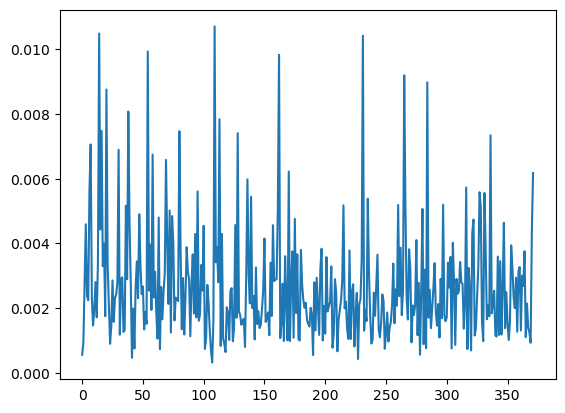

In [87]:
#example of output probabilities for undescribed insect
plt.plot(val_predicted_probs_genus[-1].cpu())
#plt.savefig("peaks10.png")

In [88]:
image_val_labels

tensor([ 30,  95, 199,  ..., 265,  69,  45])

In [89]:
val_predicted_labels

tensor([977, 946, 946,  ..., 325, 943, 696])

In [90]:
val_predicted_labels_genus

tensor([ 16,  95, 246,  ..., 196, 240, 109])

# top2 method to choose either genus or species as output

In [91]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 10000 for x in range(0, 10000, 1000)]
for t in possible_thresholds:
    thresholds.append(t)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert val_predicted_labels[i]==val_predicted_probs[i].argmax(), f"{val_predicted_labels[i]}=={val_predicted_probs[i].argmax()}"
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if  False and (top2.values[0]-top2.values[1]) >t*top2.values[0]:#species 
            print(f"threshold:{t}")
            n_undescribed_samples+=1
        else:#genus
            #print(f"genus:{t}")

            n_undescribed_samples+=1
            #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
            #ATTENZIONE QUA E' DIVERSO
            print(f"bestgenus{genus_of_best_species.item()},predicted:{val_predicted_labels_genus[i]},real{image_val_labels[i]}")
            if val_predicted_labels_genus[i].item() == image_val_labels[i].item():#guessed genus is correct
                #n_correct_described_samples+=1
                n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    #fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    #correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_21854/3344680774.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


bestgenus58,predicted:16,real30
bestgenus198,predicted:95,real95
bestgenus198,predicted:246,real199
bestgenus187,predicted:271,real365
bestgenus58,predicted:111,real136
bestgenus58,predicted:203,real136
bestgenus96,predicted:196,real8
bestgenus100,predicted:336,real65
bestgenus54,predicted:16,real326
bestgenus58,predicted:20,real68
bestgenus11,predicted:81,real230
bestgenus297,predicted:260,real8
bestgenus127,predicted:216,real298
bestgenus364,predicted:214,real352
bestgenus127,predicted:218,real318
bestgenus193,predicted:54,real68
bestgenus215,predicted:60,real136
bestgenus297,predicted:369,real282
bestgenus43,predicted:353,real93
bestgenus157,predicted:34,real25
bestgenus14,predicted:161,real26
bestgenus75,predicted:17,real289
bestgenus211,predicted:6,real21
bestgenus15,predicted:152,real118
bestgenus16,predicted:280,real311
bestgenus162,predicted:57,real354
bestgenus17,predicted:280,real26
bestgenus177,predicted:21,real127
bestgenus336,predicted:233,real26
bestgenus28,predicted:217,

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [92]:
for index in range(0,len(correct_genus_rate),1):
    print(index)
    print(correct_genus_rate[index])
    #print(correct_species_rate[index])
    print('\n\n')

0
0.0029507452523265493



1
0.0029507452523265493



2
0.0029507452523265493



3
0.0029507452523265493



4
0.0029507452523265493



5
0.0029507452523265493



6
0.0029507452523265493



7
0.0029507452523265493



8
0.0029507452523265493



9
0.0029507452523265493





In [70]:
thresholds

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Best harmonic mean 0.0006568953483598145
Best threshold 0.1


IndexError: list index out of range

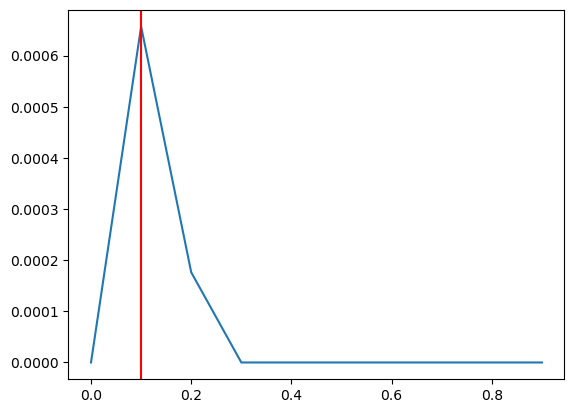

In [54]:
numerator = [2*a*b for a,b in zip(correct_genus_rate,correct_species_rate)]
denominator = [a+b for a,b in zip(correct_genus_rate,correct_species_rate)]
harmonic_mean = [a/b for a,b in zip(numerator,denominator)]
plt.plot(thresholds,harmonic_mean)
print("Best harmonic mean",max(harmonic_mean))
print("Best threshold",thresholds[harmonic_mean.index(max(harmonic_mean))])
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Harmonic mean of species and genus correct rate")
plt.xlabel("threshold")
plt.ylabel("Harmonic mean")
plt.legend()
#plt.savefig("testoldfeatures.png")

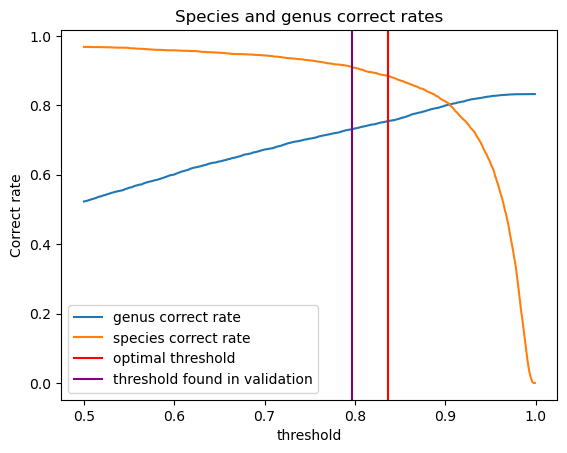

In [253]:
plt.plot(thresholds,correct_genus_rate[:],label="genus correct rate")
plt.plot(thresholds,correct_species_rate[:],label="species correct rate")
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Species and genus correct rates")
plt.xlabel("threshold")
plt.ylabel("Correct rate")
plt.legend()
#plt.savefig("testoldfeaturesCR.png")

In [256]:
correct_genus_rate[index_of_threshold]

0.7313172043010753

In [257]:
correct_species_rate[index_of_threshold]

0.9094188376753507

In [258]:
harmonic_mean[index_of_threshold]

0.8107015691644405

In [259]:
#np.save("correct_rates/oldTestCGR.npy",correct_genus_rate)
#np.save("correct_rates/oldTestCSR.npy",correct_species_rate)

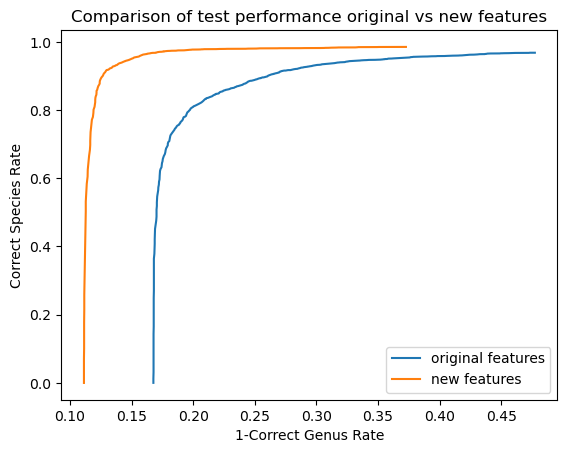

In [268]:
plt.plot(1-np.load("correct_rates/oldTestCGR.npy"),np.load("correct_rates/oldTestCSR.npy"),label='original features')
plt.plot(1-np.load("correct_rates/ourTestCGR.npy"),np.load("correct_rates/ourTestCSR.npy"),label="new features")
plt.title("Comparison of test performance original vs new features")
plt.xlabel("1-Correct Genus Rate")
plt.ylabel("Correct Species Rate")

plt.legend()
plt.savefig("test_comparison.png")

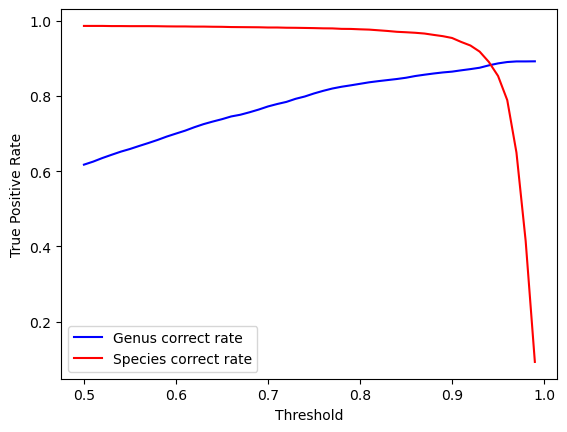

In [208]:
plt.plot(thresholds[-100:], correct_genus_rate[-100:], "-b", label="Genus correct rate")
plt.plot(thresholds[-100:], correct_species_rate[-100:], "-r", label="Species correct rate")

plt.xlabel("Threshold")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("GenusSpeciesCorrectRate.png")